In [38]:
# Read readme.md from github
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Challenge_1/"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Challenge_1


## Import packages

In [39]:
# Fix randomness and hide warnings
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

In [40]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

## Import data

In [41]:
data = np.load('new_dataset.npz', allow_pickle=True) #If you are running it using Colab

In [42]:
# Find unique labels and count them
unique, counts = np.unique(data["labels"], return_counts=True)
for i in range(len(unique)):
    print(unique[i], ":", counts[i])

healthy : 3060
unhealthy : 1790


In [43]:
# Load labels
label_indexes = data["labels"]

In [44]:
labels = np.unique(label_indexes)  # used in confusion matrix later

In [45]:
# Extract classes separately
healthy_labels = np.where(label_indexes == "healthy")[0]  # labels[labels == 'healthy']
unhealthy_labels = np.where(label_indexes == "unhealthy")[0]  # labels[labels == 'unhealthy']

In [46]:
# Extract images based on classes
healthy_images = data["data"][healthy_labels][:1000]
unhealthy_images = data["data"][unhealthy_labels][:1000]

### Preproces images

### Prepare Data

In [59]:
X = np.concatenate([healthy_images, unhealthy_images], axis=0)

# Create labels: 0 for 'healthy plants', 1 for 'unhealthy plants'
y = np.concatenate(
    [np.zeros(len(healthy_images)), np.ones(len(unhealthy_images))], axis=0
)
y = to_categorical(y, len(np.unique(y)))

### Split data

In [60]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, random_state=seed, test_size=0.25, stratify=y
)
# Print shapes of the datasets
print(f"X_train shape: {X_train_val.shape}, y_train shape: {y_train_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (1500, 96, 96, 3), y_train shape: (1500, 2)
X_test shape: (500, 96, 96, 3), y_test shape: (500, 2)


## Architecture

In [61]:
mobile = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

for layer in mobile.layers[:-30]: #from 0 to len(layers)-30 layers are not trainable
  layer.trainable = False

inputs = Input(shape=(96, 96, 3))
x = mobile(inputs)
x = Dense(100, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)


model = Model(inputs=inputs, outputs=predictions)
optimizer = Adam(lr=learning_rate)

model.compile(optimizer=optimizer,
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

#model.summary()
# for i, layer in enumerate(mobile.layers):
#    print(i, layer.name, layer.trainable)

In [62]:
earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='max',
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

In [63]:
history = model.fit(
    x = preprocess_input(X_train_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train_val,
    validation_data = (preprocess_input(X_test), y_test), # We need to apply the preprocessing thought for the MobileNetV2 network
    batch_size = 96,
    epochs = 30,
    callbacks = [earlystop, reducelr]

).history

Epoch 1/30
16/16 [==============================] - 9s 172ms/step - loss: 0.6522 - accuracy: 0.7020 - val_loss: 0.8167 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 1s 69ms/step - loss: 0.1610 - accuracy: 0.9467 - val_loss: 0.7216 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 1s 71ms/step - loss: 0.0357 - accuracy: 0.9900 - val_loss: 1.5711 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 1s 56ms/step - loss: 0.0129 - accuracy: 0.9973 - val_loss: 2.9393 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - 1s 54ms/step - loss: 0.0133 - accuracy: 0.9973 - val_loss: 2.3262 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 6/30
16/16 [==============================] - 1s 54ms/step - loss: 0.0120 - accuracy: 0.9953 - val_loss: 1.5204 - val_accuracy: 0.7060 - lr: 0.0010
Epoch 7/30
15/16 [===========================>..] - ETA: 0s - loss: 0.0145 

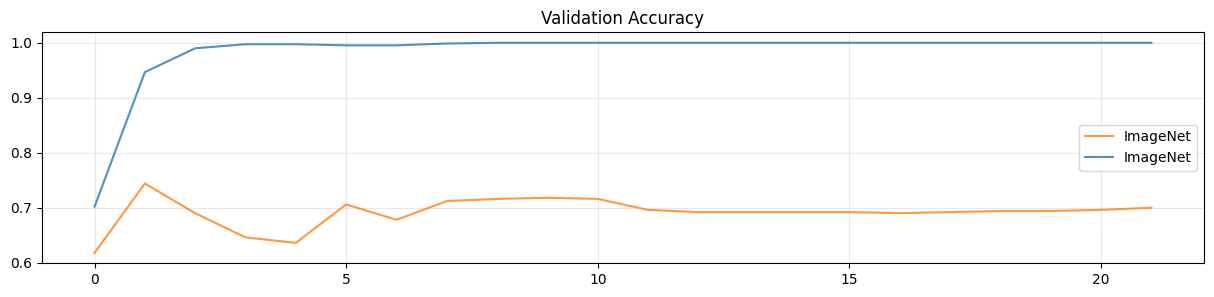

In [64]:
# Plot validation accuracy for different models
plt.figure(figsize=(15, 3))
plt.plot(history['val_accuracy'], label='ImageNet', alpha=0.8, color='#ff7f0e')
plt.plot(history['accuracy'], label='ImageNet', alpha=0.8)
plt.title('Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Show the plots
plt.show()